In [49]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, istft
import tensorflow as tf
from ipywidgets import interact
from code.stftprocessing import StftDataset
from code.dsvisual import DatasetVisualizer
from tqdm import tqdm
import datetime


In [3]:
folder = "training/new_small"
base = "noisy_small"
target = "pure_small"

folder = "training/original training"
base = "noisy"
target = "pure"

test_folder = "training/test set"
test_base = "noisy_test"
test_target = "pure_test"


In [4]:
noisy_stft = StftDataset()
pure_stft = StftDataset()

noisy_stft.load(folder, base)
pure_stft.load(folder, target)

# test sets
noisy_test_stft = StftDataset()
pure_test_stft = StftDataset()
noisy_test_stft.load(test_folder, test_base)
pure_test_stft.load(test_folder, test_target)

Files loaded.
Files loaded.
Files loaded.
Files loaded.


In [6]:
noisy_stft.get_data().shape

(430848, 129, 9, 2)

In [7]:
# get the amplitudes of training and test sets
examples = noisy_stft.get_data()[:,:,:,0]
labels = pure_stft.get_data()[:,:,:,0]

stride_reduce = 100
examples_test = noisy_test_stft.get_data()[::stride_reduce,:,:,0]
labels_test = pure_test_stft.get_data()[::stride_reduce,:,:,0]

examples_test_phase = noisy_test_stft.get_data()[::stride_reduce,:,:,1]
labels_test_phase = pure_test_stft.get_data()[::stride_reduce,:,:,1]

# build the dataset from tensorflow functions
train_dataset = tf.data.Dataset.from_tensor_slices((examples, labels))
test_dataset = tf.data.Dataset.from_tensor_slices((examples_test, labels_test))

2023-03-28 17:30:24.572763: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-28 17:30:24.588906: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-28 17:30:24.617210: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-03-28 17:30:24.633189: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: alex-home-PC-X570
2023-03-28 17:30:24.633205: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: alex-home-PC-X570
2023-03-28 17:30:24.658443: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.89.2
2023-03-28 17:30:24.658490: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.85.5
2

In [8]:
train_dataset
# test_dataset

<TensorSliceDataset shapes: ((129, 9), (129, 9)), types: (tf.float64, tf.float64)>

In [9]:
input_shape = (129, 9 , 2)
input_shape = (129, 9)

In [10]:
BATCH_SIZE = 512
SHUFFLE_BUFFER_SIZE = 2000

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [33]:
dropout_rate = 0.2
factor = 2

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),

    tf.keras.layers.Dense(units = 125*factor, activation='relu'),
    tf.keras.layers.Dropout(rate=dropout_rate),
    tf.keras.layers.Dense(units = 75*factor, activation='relu'),
    tf.keras.layers.Dropout(rate=dropout_rate*0.25),

    tf.keras.layers.Dense(units = 50*factor, activation='relu'),
    tf.keras.layers.Dropout(rate=dropout_rate*0.25),

    tf.keras.layers.Dense(units = 75*factor, activation='relu'),
    tf.keras.layers.Dropout(rate=dropout_rate),


    tf.keras.layers.Dense(units = 129*9, activation='relu'),
    # tf.keras.layers.Dense((128,9,2), activation='relu'),
    # tf.keras.layers.Dense((128,9,2), activation='relu'),
    # tf.keras.layers.Dense((128,9,2), activation='relu'),
    # tf.keras.layers.Conv2D(3,2, activation='relu', input_shape=input_shape)
    tf.keras.layers.Reshape(target_shape=input_shape)
])

model.compile(optimizer="adam",
              loss="mse",
              )

In [34]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 1161)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 250)               290500    
_________________________________________________________________
dropout_16 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 150)               37650     
_________________________________________________________________
dropout_17 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               15100     
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)              

In [36]:
model.fit(train_dataset,validation_data=test_dataset, epochs=200)


Epoch 1/200
842/842 [==============================] - 34s 38ms/step - loss: 5.3336e-05 - val_loss: 5.9216e-05
Epoch 2/200
842/842 [==============================] - 16s 17ms/step - loss: 3.1081e-05 - val_loss: 4.1663e-05
Epoch 3/200
842/842 [==============================] - 15s 16ms/step - loss: 2.4134e-05 - val_loss: 3.6561e-05
Epoch 4/200
842/842 [==============================] - 14s 16ms/step - loss: 2.0832e-05 - val_loss: 3.4307e-05
Epoch 5/200
842/842 [==============================] - 14s 16ms/step - loss: 1.8633e-05 - val_loss: 3.3382e-05
Epoch 6/200
842/842 [==============================] - 14s 16ms/step - loss: 1.7149e-05 - val_loss: 3.2979e-05
Epoch 7/200
842/842 [==============================] - 14s 16ms/step - loss: 1.5959e-05 - val_loss: 3.3031e-05
Epoch 8/200
842/842 [==============================] - 14s 16ms/step - loss: 1.5075e-05 - val_loss: 3.3005e-05
Epoch 9/200
842/842 [==============================] - 14s 16ms/step - loss: 1.4379e-05 - val_loss: 3.1922e-05
E

## Looking at predictions
Inspecting the predictions of the model on the training set.

In [37]:
predictions = model.predict(examples[:10000,:,:])

In [38]:
np.var(predictions)

0.00011937795

In [39]:
predictions.shape

def plot_example(index):
    prediction = predictions[index]
    actual = labels[index]
    noisy = examples[index]
    
    fig, [ax1, ax2, ax3, ax4] = plt.subplots(1,4)
    ax2.imshow(prediction, aspect = "auto")
    ax3.imshow(actual, aspect= "auto")
    ax1.imshow(noisy, aspect="auto")
    ax4.imshow(actual-prediction, aspect="auto")
    plt.show()

In [40]:
interact(plot_example, index=(0, 9999, 1))

interactive(children=(IntSlider(value=4999, description='index', max=9999), Output()), _dom_classes=('widget-i…

<function __main__.plot_example(index)>

In [41]:
def plot_time_domain( index):

    test_noisy = noisy_stft.get_data()[index,:,:,0]
    test_noisy_phase = noisy_stft.get_data()[index,:,:,1]

    test_pure = labels[index,:,:]
    test_pure_phase = noisy_stft.get_data()[index,:,:,1]

    model_amp = predictions[index]
    noisy_phase = noisy_stft.get_data()[index,:,:,1]

    fig, [ax1, ax2] =plt.subplots(1,2)
    t, signal_pure = istft(test_pure*np.exp(1j*test_pure_phase), fs = 1./5.)
    t, signal_model = istft(model_amp*np.exp(1j*noisy_phase), fs = 1./5.)
    t, signal_example = istft(test_noisy*np.exp(1j*test_noisy_phase), fs = 1./5.)

    fig.set_size_inches((12,10))
    ax1.plot(t,signal_example)
    ax2.plot(t, signal_model)
    ax2.plot(t, signal_pure, alpha=0.5, color="red")
    plt.show()

In [42]:
interact(plot_time_domain, index = (0,9999,1))

interactive(children=(IntSlider(value=4999, description='index', max=9999), Output()), _dom_classes=('widget-i…

<function __main__.plot_time_domain(index)>

## Visualize the effect on the test set
Previous visualizations were for the training set only.

Check the influence of the test set here.

In [43]:
predictions_test = model.predict(examples_test)

In [44]:
examples_test = noisy_test_stft.get_data()[::stride_reduce,:,:,0]
labels_test = pure_test_stft.get_data()[::stride_reduce,:,:,0]

examples_test_phase = noisy_test_stft.get_data()[::stride_reduce,:,:,1]
labels_test_phase = pure_test_stft.get_data()[::stride_reduce,:,:,1]

In [45]:
def plot_time_domain_test( index):

    # get the test set prediction
    test_noisy = examples_test[index]
    test_noisy_phase = examples_test_phase[index]
    
    # the pure example from the test set
    test_pure = labels_test[index]
    test_pure_phase = labels_test_phase[index]

    model_amp = predictions_test[index]
    noisy_phase = examples_test_phase[index]
    
    fig, [ax1, ax2] =plt.subplots(1,2)
    t, signal_pure = istft(test_pure*np.exp(1j*test_pure_phase), fs = 1./5.)
    t, signal_model = istft(model_amp*np.exp(1j*noisy_phase), fs = 1./5.)
    t, signal_example = istft(test_noisy*np.exp(1j*test_noisy_phase), fs = 1./5.)

    fig.set_size_inches((12,10))
    ax1.plot(t,signal_example)
    ax2.plot(t, signal_model)
    ax2.plot(t, signal_pure, alpha=0.5, color="red")
    plt.show()

In [46]:
interact(plot_time_domain_test, index = (0,1000,1))

interactive(children=(IntSlider(value=500, description='index', max=1000), Output()), _dom_classes=('widget-in…

<function __main__.plot_time_domain_test(index)>

## Store the model
Storing the model after a long training session.

In [47]:
model_folder = "model/"

In [51]:

# Get the current date
now = datetime.datetime.now()

# Format the date as "day-month-year"
date_str = now.strftime("%d-%m-%Y")

model_name = f"model-{date_str}"

path = model_folder + model_name
model.save(path)

2023-03-28 18:43:33.603096: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/model-28-03-2023/assets


## Analysis of maximum values
Looking at maximum values of amplitude over the whole array

In [147]:
test_example = noisy_stft.get_data()[0]
shape = test_example.shape
test_example_reshaped = noisy_stft.get_data()[0].reshape((1, shape[0], shape[1], shape[2]))

test_pure = pure_stft.get_data()[0]

In [148]:
test_pure[:,:,0].max()

0.1167289817731223

Todo
Normalize the phase and amplitude values..

In [27]:
amps_noisy =noisy_stft.get_data()[:,:,:,0]

In [28]:
amps_noisy_flattened = amps_noisy.flatten()

(array([1.0101877e+07, 1.1225070e+06, 1.9600700e+05, 1.0042300e+05,
        5.1438000e+04, 2.1964000e+04, 9.8380000e+03, 4.6260000e+03,
        1.1690000e+03, 1.5100000e+02]),
 array([2.14359953e-11, 1.67539747e-02, 3.35079495e-02, 5.02619242e-02,
        6.70158989e-02, 8.37698737e-02, 1.00523848e-01, 1.17277823e-01,
        1.34031798e-01, 1.50785773e-01, 1.67539747e-01]),
 <BarContainer object of 10 artists>)

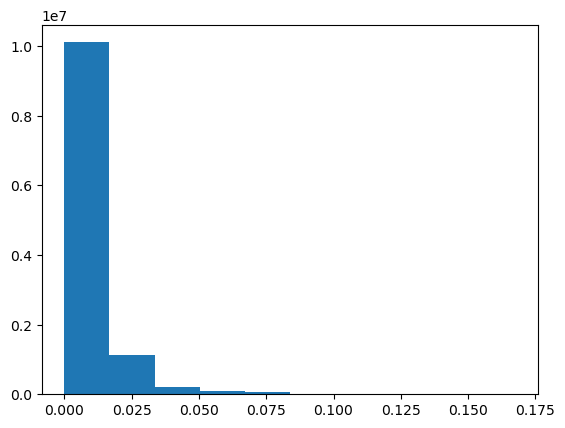

In [29]:
plt.hist(amps_noisy_flattened)

In [30]:
amps_noisy_max = amps_noisy.max(axis=2).max(axis=1)

In [31]:
amps_noisy_max.shape

(10000,)

(array([ 153.,  364., 2132., 2197., 1479., 1392., 1000.,  879.,  345.,
          59.]),
 array([0.04645806, 0.05856623, 0.0706744 , 0.08278256, 0.09489073,
        0.1069989 , 0.11910707, 0.13121524, 0.14332341, 0.15543158,
        0.16753975]),
 <BarContainer object of 10 artists>)

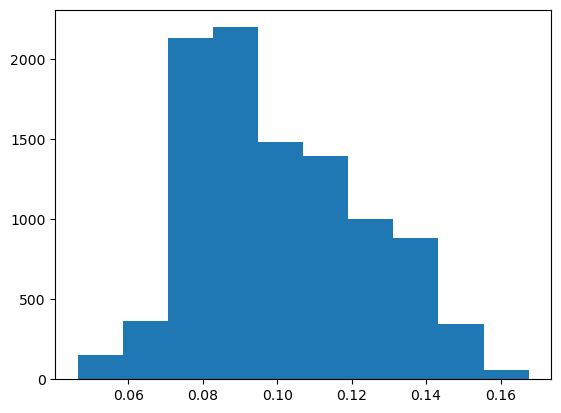

In [32]:
plt.hist(amps_noisy_max)